In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
raw = pd.read_csv('./datasets/train.csv')

In [3]:
# function to create box or swarmplots for a certain categorical variable, sorted by the median

def cat_plotter(x, kind='swarm',line=True, y='SalePrice',df=raw):
    
    order = list(pd.pivot_table(data=df, columns=x,
                    values=y, 
                    aggfunc=np.median).T.sort_values(by=y).reset_index()[x])
    
    plt.figure(figsize = (10,4))
    
    if kind == 'box':
    
        ax = sns.boxplot(x=x, y=y, data=df, order=order)
        
    elif kind == 'swarm':
        ax = sns.swarmplot(x=x, y=y, data=df, order=order)
        
    elif kind == 'both':
        ax = sns.boxplot(x=x, y=y, data=df, order=order,color='white')
        sns.swarmplot(x=x, y=y, data=df, order=order, ax=ax)
        
    
    if line:    
        sns.pointplot(x=x, y=y, data=df[[x, y]].groupby(x, as_index=False).median().sort_values(y), ax=ax)
        
    
    
    ax.set_title(x,fontsize=20)
    return ax

#### I am creating a dataframe named `data_instructions` , which will help to impute null values in the testing set later on

In [4]:
all_nulls = raw.isnull().sum().sort_values(ascending=False).head(26)
data_instructions = pd.DataFrame(all_nulls)
data_instructions.drop(0,axis=1,inplace=True)
data_instructions['Replacement'] = 0

## Check for Null Values


#### I am going to explore all of the columns with Null values in this dataset. I will be reusing the following piece of code throughout:

``` cat_plotter(raw.isnull().sum().sort_values(ascending=False).head(1).index.tolist()[0]) ```

```raw[raw.isnull().sum().sort_values(ascending=False).head(1).index.tolist()[0]].value_counts()```

This will return two important objects pertaining to the column with the current highest amount of null values: A swarm plot of all values (sorted by median sale price) and a list of non-null value counts for that column.

In [5]:
raw.isnull().sum().sort_values(ascending=False).head(21)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Cond        114
Garage Qual        114
Garage Yr Blt      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
dtype: int64

### Exploring the columns with null values

Gd    4
Fa    2
TA    2
Ex    1
Name: Pool QC, dtype: int64

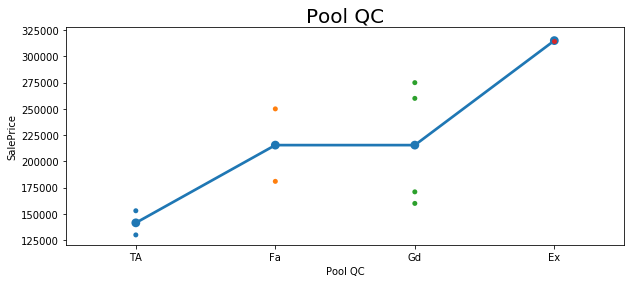

In [6]:
cat_plotter(raw.isnull().sum().sort_values(ascending=False).head(1).index.tolist()[0])

raw[raw.isnull().sum().sort_values(ascending=False).head(1).index.tolist()[0]].value_counts()

The vast majority of values in this column are null. I assume that this is because most people don't have pools (not surprising for Ames, Iowa).

In [7]:
raw.isnull().sum().sort_values(ascending=False).head(6)

Pool QC         2042
Misc Feature    1986
Alley           1911
Fence           1651
Fireplace Qu    1000
Lot Frontage     330
dtype: int64

In addition to 'Pool QC', it seems like the next four items are similarly "optional" house items that were probably left blank because the house didn't contain that feature. I will change the null values in these columns to 'None'.

In [8]:
initial_null_cols = raw.isnull().sum().sort_values(ascending=False).head(5).index.tolist()
[raw[each].fillna('None', inplace=True) for each in initial_null_cols];

for each in initial_null_cols:
    data_instructions['Replacement'][each] = 'None'

In [9]:
raw.isnull().sum().sort_values(ascending=False).head(6)

Lot Frontage     330
Garage Yr Blt    114
Garage Finish    114
Garage Qual      114
Garage Cond      114
Garage Type      113
dtype: int64

Lot frontage is described in the data dictionary as:

> Lot Frontage (Continuous): Linear feet of street connected to property

I assume that this is another feature that a lot of other homes have, but it is is a numerical (continuous) value rather than a categorical one. I will use a scatterplot to visualize the relationship between 'Lot Frontage' and the target variable.

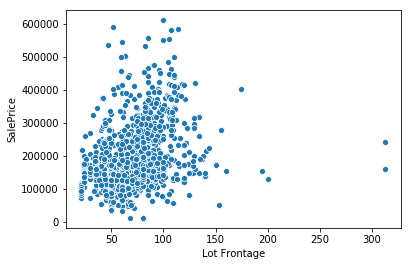

In [10]:
sns.scatterplot(raw['Lot Frontage'], raw['SalePrice']);

Lot frontage seems somewhat linear to SalePrice, but quite co-linear with Lot Area. Maybe I should fill lot frontage's null value's with zeros, and combine Lot Area and Lot Frontage into its own feature? 

Maybe Lot Frontage is superfluous and should be dropped? Maybe I should create a feature that combines it with 'Lot Area', and an additional binary feature that specifies whether there is any "Lot Frontage"?

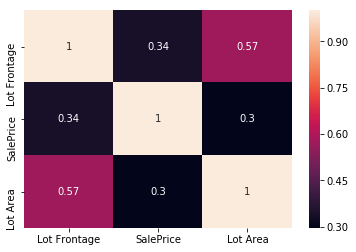

In [11]:
sns.heatmap(raw[['Lot Frontage','SalePrice','Lot Area']].corr(), annot=True)

For the purpose of filling up all null values, it makes sense to impute the 'Lot Frontage' null values with 0, since it's a measure of square footage. Same anything with 'SF' or 'Area' in the column name.

Any null values in columns with 'Bath' or 'Cars' in them should also be filled in with zeroes, since those columns represent additional features that are both optional and numerical.

In [12]:
other_null_colls = raw.isnull().sum().sort_values(ascending=False).head(21).index.tolist()

area_etc_strings = ['SF','Area','Frontage', 'Bath', 'Cars']

for each in other_null_colls:
    for string in area_etc_strings:
        if string in each:
            raw[each].fillna(0,inplace=True)
            data_instructions['Replacement'][each] = 0

In [13]:
raw.isnull().sum().sort_values(ascending=False).head(6)

Garage Cond      114
Garage Yr Blt    114
Garage Finish    114
Garage Qual      114
Garage Type      113
Bsmt Exposure     58
dtype: int64

I want to look more into Garage Yr Blt before deciding what values to impute for the Null Values

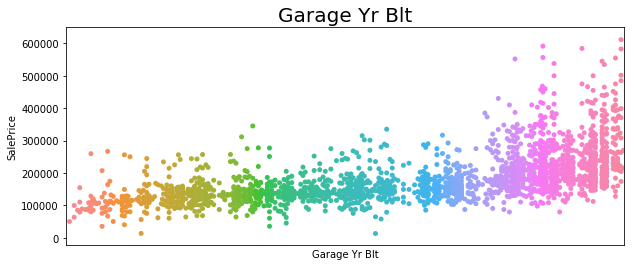

In [14]:
cat_plotter('Garage Yr Blt', line=False)
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)

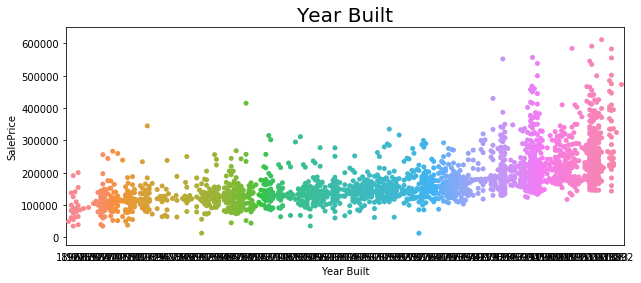

In [15]:
cat_plotter('Year Built', line=False)
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=True)

Based on the plot above, it does seem like Garage Yr Blt may play a role in determining 'SalesPrice', and that i probably shouldn't get impute it as 0 or 'None.' Perhaps look to one of the other year columns?

In [16]:
pd.pivot_table(data=raw, columns='Garage Yr Blt',
                    values='SalePrice', 
                    aggfunc=np.median).T.sort_values(by='SalePrice',ascending=False).reset_index().head(10)

,Garage Yr Blt,SalePrice
0,2009.0,308030.0
1,2008.0,290083.5
2,2207.0,267300.0
3,2006.0,249850.0
4,1918.0,239000.0
5,2007.0,235063.0
6,2001.0,226000.0
7,1993.0,224250.0
8,2010.0,223848.5
9,2000.0,215000.0


Looks like there is an incorrect value for 'Garage Yr Blt'; one of the has the year as 2207, which is obviously impossible. That will have to have a new imputed value, as well.

In [17]:
raw.loc[raw['Garage Yr Blt'] > 2010][['Garage Yr Blt', 'Year Built', 'Year Remod/Add']]

,Garage Yr Blt,Year Built,Year Remod/Add
1699,2207.0,2006,2007


Thankfully, this is the only row with a 'Garage Yr Blt' over the range of possible values. I am going to assume that they meant to imput 2008 (the same as 'Year Redom/Add', but typoed)

In [18]:
raw.loc[1699, 'Garage Yr Blt'] = raw.loc[1699, 'Year Remod/Add']

Interestingly enough, it seems like the lowest value for 'Year Remod/Add' is 1950. It is also the most popular value, by far. Maybe this was what was imputed in instances where there was no remodel? 

In [19]:
raw['Year Remod/Add'].sort_values().head()

814     1950
1077    1950
1079    1950
362     1950
1088    1950
Name: Year Remod/Add, dtype: int64

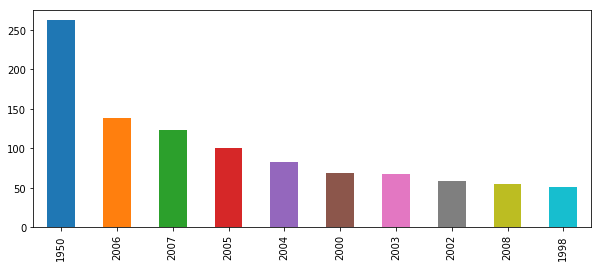

In [20]:
plt.figure(figsize = (10,4))

raw['Year Remod/Add'].value_counts().head(10).plot.bar()

In [21]:
pd.DataFrame(raw['Garage Yr Blt'].value_counts()).reset_index().sort_values('index').head(10)

,index,Garage Yr Blt
97,1895.0,1
94,1896.0,1
86,1900.0,3
79,1910.0,5
88,1914.0,2
83,1915.0,4
77,1916.0,5
96,1917.0,1
93,1918.0,1
95,1919.0,1


Does not look like that same methodology was used for Garage Yr Blt (which makes sense, because there were many null values to impute).

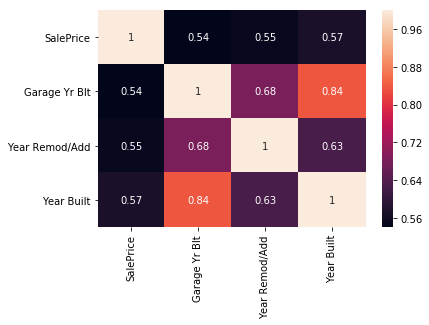

In [22]:
sns.heatmap(raw[['SalePrice', 'Garage Yr Blt', 'Year Remod/Add', 'Year Built']].corr(), annot=True);

It seems like Garage Yr Blt and Yr Built and pretty co-linear. If I'm going to impute a value for the nulls in 'Garage Yr Blt', it probably makes sense to use 'Year Built." Maybe one of the regularization methods later will drop it? Maybe a column specifying whether or not someone has a garage would be helpful?

It seems like 'Garage Yr Built' might have a somewhat linear relationship with 'SalePrice', so I don't want to necessarily label it has "0" or "None". For now, I will fill in the null values in this column with that row's 'Year Built' value.

In [23]:
raw['Garage Yr Blt'] = raw['Garage Yr Blt'].fillna(value=raw['Year Built'])
data_instructions.drop('Garage Yr Blt',axis=0,inplace=True)

In [24]:
raw.isnull().sum().sort_values(ascending=False).head(12)

Garage Cond       114
Garage Finish     114
Garage Qual       114
Garage Type       113
Bsmt Exposure      58
BsmtFin Type 2     56
BsmtFin Type 1     55
Bsmt Cond          55
Bsmt Qual          55
Mas Vnr Type       22
Lot Area            0
Year Remod/Add      0
dtype: int64

For anything else with 'Garage' or 'Bsmt' in the column title, I will change the nulls to 'None'

In [25]:
gar_bsmt_strings = ['Garage','Bsmt', 'Type']

for each in other_null_colls:
    for string in gar_bsmt_strings:
        if string in each:
            raw[each].fillna('None',inplace=True)
            data_instructions['Replacement'][each] = 'None'

## All Nulls Removed!

In [26]:
raw.isnull().sum().sum()

0

I am also going to drop 'PID', since it is a superfluous column, and set 'ID' as the index for the rest of the modeling process.

In [27]:
raw.drop('PID',axis=1,inplace=True)

In [28]:
raw.set_index('Id',inplace=True)

In [29]:
raw.to_csv('./datasets/train_nonulls.csv')

In [30]:
data_instructions.head(6)

,Replacement
Pool QC,None
Misc Feature,None
Alley,None
Fence,None
Fireplace Qu,None
Lot Frontage,0


In [31]:
data_instructions.to_csv('./datasets/data_instructions.csv')

### I am also creating a dataframe containing the datatypes for each attribute, to aid with imputing null values in the test set.

In [32]:
train_aggs = pd.DataFrame(raw.columns[1:].tolist())
train_aggs.columns = ['Attribute']
train_aggs['D_Type'] = train_aggs['Attribute'].apply(lambda x: raw[x].dtype)

In [33]:
train_aggs.head()

,Attribute,D_Type
0,MS Zoning,object
1,Lot Frontage,float64
2,Lot Area,int64
3,Street,object
4,Alley,object


In [34]:
train_aggs.to_csv('./datasets/train_agg_dtypes.csv')